# sell-short-in-may-and-go-away

see: https://en.wikipedia.org/wiki/Sell_in_May

The reason for this example is to demonstrate short selling (algo), and short selling using adjust_percent function (algo2).  

algo  - Sell short in May and go away, buy to cover in Nov  
algo2 - first trading day of the month, adjust position to 50%  

(Select the one you want to call in the Strategy.run() function

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
capital = 10000
start = datetime.datetime(2015, 10, 30)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define Strategy Class

In [5]:
class Strategy:

    def __init__(self, symbol, capital, start, end):

        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        
        self.ts = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            shares = 0

            # Buy to cover (at the open on first trading day in Nov)
            if self.tlog.shares > 0:
                if (row.month == 11 and row.first_dotm) or end_flag:
                    shares = self.tlog.buy2cover(date, row.open)

            # Sell short (at the open on first trading day in May)
            else:
                if row.month == 5 and row.first_dotm:
                    shares = self.tlog.sell_short(date, row.open)

            if shares > 0:
                pf.DBG("{0} SELL SHORT  {1} {2} @ {3:.2f}".format(
                       date, shares, self.symbol, row.open))
            elif shares < 0:
                pf.DBG("{0} BUY TO COVER {1} {2} @ {3:.2f}".format(
                       date, -shares, self.symbol, row.open))
            # Record daily balance
            self.dbal.append(date, close)

    def _algo2(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            shares = 0

            # On the first day of the month, adjust short position to 50%
            if (row.first_dotm or end_flag):
                weight = 0 if end_flag else 0.5
                self.tlog.adjust_percent(date, close, weight, pf.Direction.SHORT)

            # Record daily balance
            self.dbal.append(date, close)

    def run(self):
        self.ts = pf.fetch_timeseries(self.symbol)
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end,
                                         use_adj=True)
        # add calendar columns
        self.ts = pf.calendar(self.ts)
        
        self.tlog = pf.TradeLog(self.symbol)
        self.dbal = pf.DailyBal()
        
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start)

        # Pick either algo or algo2
        self._algo()
        #self._algo2()
        
        self._get_logs()
        self._get_stats()
        
        
    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        self.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [6]:
s = Strategy(symbol, capital, start, end)
s.run()

In [7]:
s.rlog.head()

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2016-05-02,0,180.63,55,entry,SHRT,SPY
1,2016-11-01,1,187.79,55,exit,SHRT,SPY
2,2017-05-01,2,212.66,45,entry,SHRT,SPY
3,2017-11-01,3,232.18,45,exit,SHRT,SPY
4,2018-05-01,4,239.60,36,entry,SHRT,SPY


In [8]:
s.tlog.head()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
0,2016-05-02,180.63,2016-11-01,187.79,-7.16,-393.64,55,-393.64,SHRT,SPY
1,2017-05-01,212.66,2017-11-01,232.18,-19.52,-878.29,45,-1271.93,SHRT,SPY
2,2018-05-01,239.60,2018-11-01,248.84,-9.25,-332.92,36,-1604.85,SHRT,SPY
3,2019-05-01,272.80,2019-11-01,284.92,-12.12,-363.71,30,-1968.56,SHRT,SPY
4,2020-05-01,269.49,2020-11-02,314.51,-45.03,-1305.78,29,-3274.34,SHRT,SPY


In [9]:
s.dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2023-12-14,6223.62,6223.62,6223.62,0,6223.62,1.00,-
2023-12-15,6223.62,6223.62,6223.62,0,6223.62,1.00,-
2023-12-18,6223.62,6223.62,6223.62,0,6223.62,1.00,-
2023-12-19,6223.62,6223.62,6223.62,0,6223.62,1.00,-
2023-12-20,6223.62,6223.62,6223.62,0,6223.62,1.00,-


Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [10]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

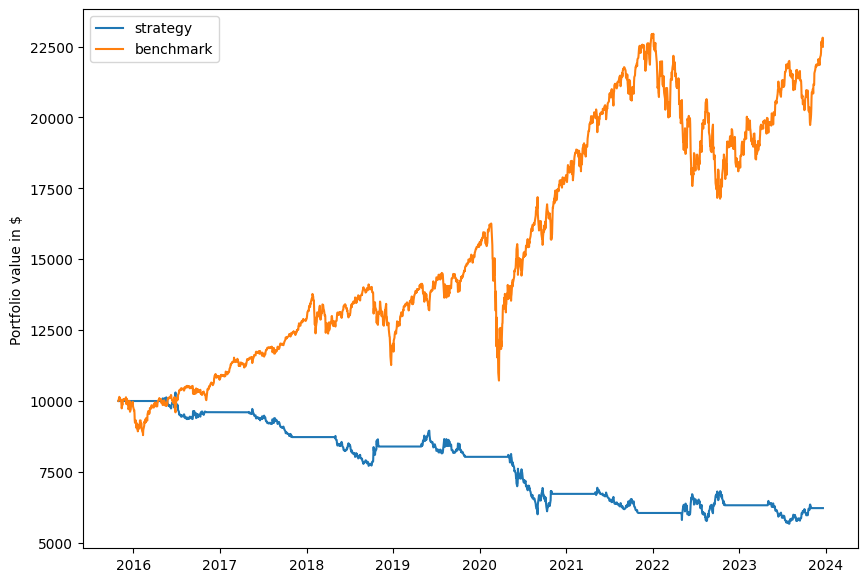

In [11]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Plot Trades

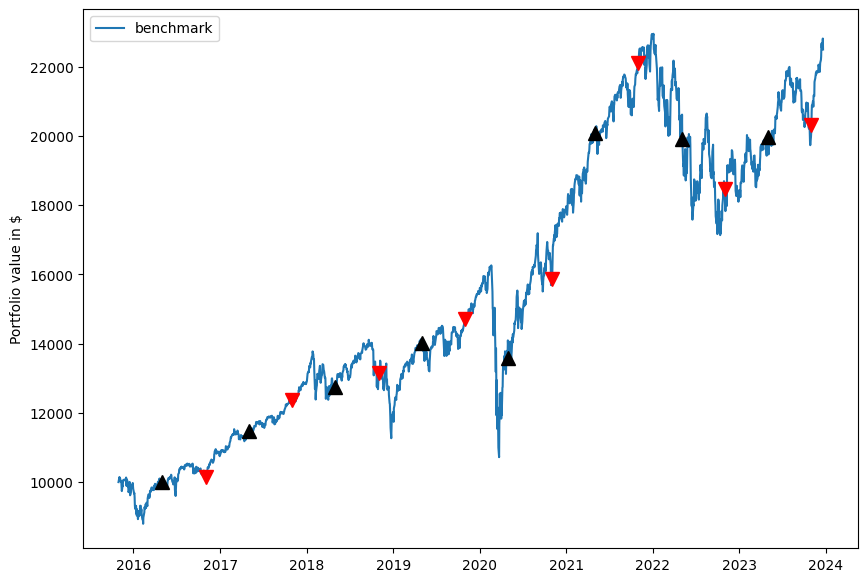

In [12]:
pf.plot_trades(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,-5.66,10.47
max_closed_out_drawdown,-44.95,-34.06
annualized_return_over_max_drawdown,0.13,0.31
best_month,12.39,23.03
worst_month,-11.08,-31.35
sharpe_ratio,-0.46,0.63
sortino_ratio,-0.56,0.76
monthly_std,2.83,4.64
annual_std,6.75,14.22


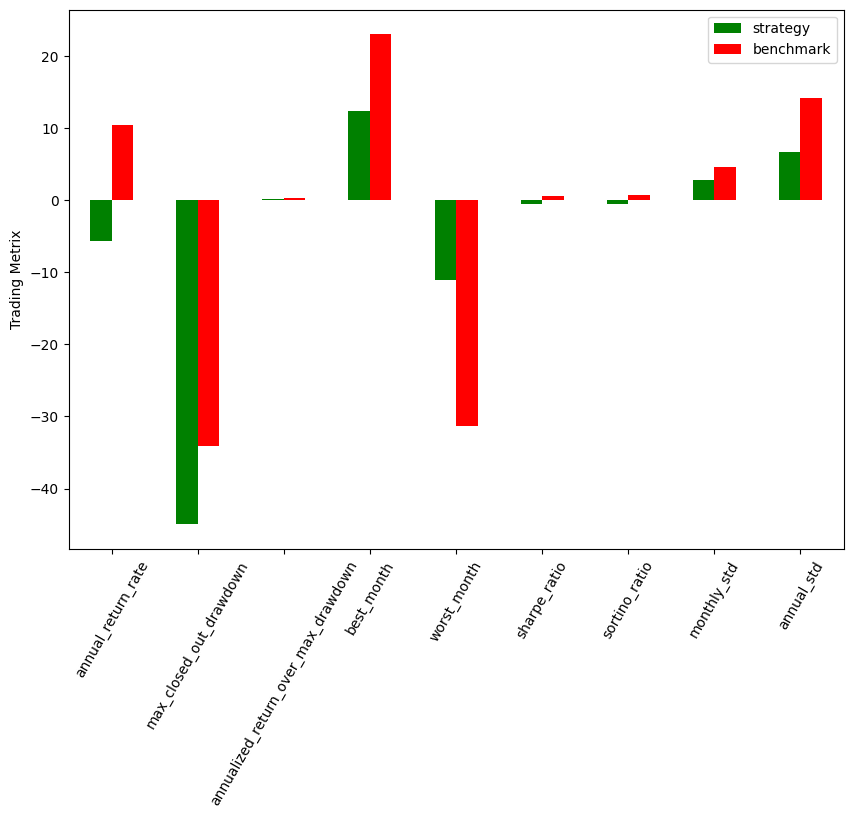

In [13]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df